Jupyter Notebook to analyze drug arrests vs ufo sighting trends

In [1]:
# Import Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
from matplotlib import rcParams

# Dictionary to convert state names to their abbreviations
from us_state_abbrev import us_state_abbrev
################################################
# Title: us_state_abbrev.py
# Author: Haque, A
# Date: 2016
# Availability: https://gist.github.com/afhaque/29f0f4f37463c447770517a6c17d08f5#file-us_state_abbrev-py
################################################

In [2]:
# Import the clean ufo data

ufo_df = pd.read_csv("Resources/usa_sights.csv")

# Keep only the columns needed for this analysis
ufo_df = ufo_df[["year", "state", "sightings"]]

ufo_df["state"] = ufo_df["state"].str.upper()
ufo_df["year"] = ufo_df["year"].astype(str)

ufo_df.head()

,year,state,sightings
0,1949,TX,1
1,1956,TX,1
2,1960,HI,1
3,1961,TN,1
4,1965,CT,1


In [3]:
# Import and clean the drug arrest data

drug_df = pd.read_csv("Resources/arrest_data.csv")
# Data from https://ucr.fbi.gov/crime-in-the-u.s

drug_df = drug_df.loc[drug_df["ages"]=="Total all ages"]
# Washington DC is removed because the ufo data was incomplete
drug_df = drug_df.loc[drug_df["state"]!="DISTRICT OF COLUMBIA"]

# Convert state names to abbreviations for merging with ufo dataframe
drug_df["state"] = drug_df["state"].str.title()
for index, row in drug_df.iterrows():
    row["state"] = us_state_abbrev[row["state"]]

drug_df.head()

,state,ages,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005
1,AL,Total all ages,220,325,306,300,"8,213","15,180","16,488","17,309","16,860","15,704"
3,AK,Total all ages,"1,159","1,475","1,547","2,341","2,491","2,050","1,716","1,759","1,701","1,885"
5,AZ,Total all ages,"29,670","30,962","27,273","30,886","30,349","35,087","34,242","35,384","35,470","35,722"
7,AR,Total all ages,"11,168","11,391","11,083","8,783","9,753","11,213","11,513","9,953","11,154","12,009"
9,CA,Total all ages,"229,083","217,520","194,290","188,188","241,547","251,740","268,763","289,449","301,406","305,745"


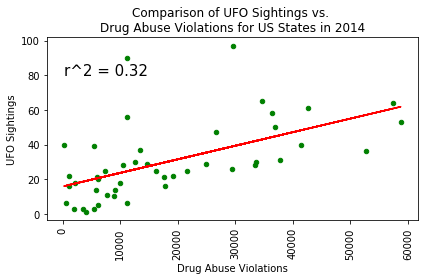

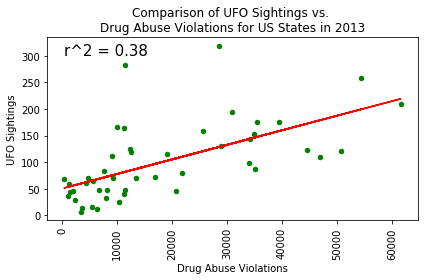

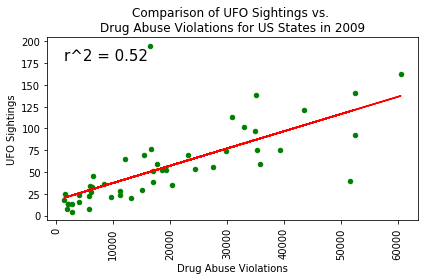

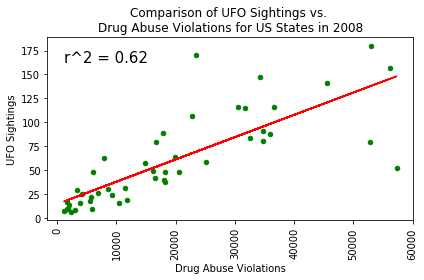

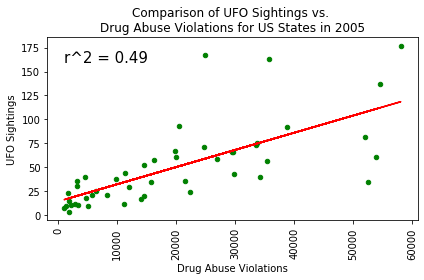

In [4]:
# Prepare the graphs

# Years to compare
years = ["2014", "2013", "2009", "2008", "2005"]

for year in years:
    # Merge ufo and drug data frames for graphing
    ufo_year = ufo_df.loc[ufo_df["year"]==year]
    drug_year = drug_df[["state", year]]
    ufo_year = ufo_year.groupby("state").count()
    ufo_drug = pd.merge(ufo_year, drug_year, on="state")
    # Make data an int for analysis
    ufo_drug[year] = ufo_drug[year].str.replace(",", "")
    ufo_drug[year] = ufo_drug[year].astype(int)
    
    # Get rid of outliers
    quartiles = ufo_drug.quantile([.25, .5, .75])
    lowerQ = quartiles[year][.25]
    upperQ = quartiles[year][.75]
    IQR = upperQ - lowerQ
    lowerBound = lowerQ - (1.5 * IQR)
    upperBound = upperQ + (1.5 * IQR)
    
    # Create dataframe without outliers
    ufo_drug = ufo_drug.loc[(ufo_drug[year]<upperBound) & (ufo_drug[year]>lowerBound)]
    
    # Graph scatter plots comparing drug arrests to ufo sightings
    rcParams.update({'figure.autolayout': True})
    ufo_drug.plot(kind="scatter", y="sightings", x=year, c="g", 
               title = f"Comparison of UFO Sightings vs. \nDrug Abuse Violations for US States in {year}")
    (slope, intercept, rvalue, pvalue, sterr) = linregress(ufo_drug[year], ufo_drug["sightings"])
    
    # Perform regession calculations
    regressValues = (slope*ufo_drug[year]) + intercept
    plt.plot(ufo_drug[year], regressValues,"red")
    plt.annotate(f"r^2 = {round(rvalue**2,2)}",(ufo_drug[year].min()+5,ufo_drug["sightings"].max()-17),fontsize=15,color="black")
    plt.xticks(rotation=90)
    plt.xlabel("Drug Abuse Violations")
    plt.ylabel("UFO Sightings")
    plt.savefig(f"Drug_Graphs/drug_ufo_{year}.png")